In [1]:
import game

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import agent

In [2]:
def visualize(stateHistory, actionHistory, rewardHistory, N):
    inventory = stateHistory[:, 0, :]
    orders = actionHistory[:, 1, :]
    serviceTimes = actionHistory[:, 0, :]
    reorderPoints = stateHistory[:, 1, :]
    
    print("Time Series")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        
        alpha = 1 if i == 2 else 0.3
#         plt.step(range(N+1), inventory[:, i] * np.roll(np.sign(orders[:, i]), -1), label="inventory")        
        plt.plot(range(N+1), inventory[:, i], label="inventory", alpha=alpha, c='b', linestyle='--', drawstyle='steps')
        plt.step(range(N+1), orders[:, i], label="order quantity", c='orange')
        if i == 2:
            plt.step(range(N+1), reorderPoints[:, i], label="reorder point", c='green')
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    print("Service Time")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        plt.step(range(N+1), serviceTimes[:, i], label="service time")
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    
    print("Inventory")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        plt.step(range(N+1), inventory[:, i] * np.sign(orders[:, i]), label="inventory")
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    print("Rewards")
    plt.figure(figsize=(20, 4))
    plt.step(range(N+1), rewardHistory)
    plt.show()

In [3]:
from tqdm import tqdm_notebook

In [19]:
learningParams = {
    "gamma": 0.2,
    "alpha": 0.8,
    "epsilon": 0.5
}

envParams = {
    "inventoryCost": [5, 1000, 1000], #[1000, 5, 1000], #
    "muDemand": 2,
    "stdDemand": 0.1, #0, #
    "retailerOrder": 10,
    "stockoutCost": 10000, 
    "N": 1000
}

In [ ]:
NSimulation = 10
NGame = 5000 

reorderPointsAll = []
meanReorderPoints = []
node0InventoriesAll = []
node0InventoryMeans = []
node1InventoriesAll = []
node1InventoryMeans = []
rewardsAll = []
rewardMeans = []
for _ in range(NSimulation):
    # create central planner
    plannerAgent = agent.Planner(learningParams, envParams["retailerOrder"])

    # training
    for _ in tqdm_notebook(range(NGame)):
        game.runEpisode(envParams, plannerAgent, train=True)
    
    # test
    plannerAgent.epsilon = 0
    stateHistory, actionHistory, rewardHistory, _ = game.runEpisode(envParams, plannerAgent, train=False)
        
    # note reorder point
    reorderPoints = stateHistory[:, 1, 2]
    reorderPointsAll.append(reorderPoints)
    meanReorderPoint = reorderPoints.mean()
    meanReorderPoints.append(meanReorderPoint)

    
    orders = actionHistory[:, 1, :]

    # note inventories 0
    node0Inventories = stateHistory[:, 0, 0] 
    node0InventoriesAll.append(node0Inventories)
    # consider inventory before order
    filterInv = np.roll(np.sign(orders[:, 0]), -1)
    node0Inventories = node0Inventories[np.where(filterInv == 1)]
    node0InventoryMean = node0Inventories.mean() if (len(node0Inventories) > 0) else 0
    node0InventoryMeans.append(node0InventoryMean)
    
    # note inventories 1
    node1Inventories = stateHistory[:, 0, 1] 
    node1InventoriesAll.append(node1Inventories)
    # consider inventory before order
    filterInv = np.roll(np.sign(orders[:, 1]), -1)
    node1Inventories = node1Inventories[np.where(filterInv == 1)]
    node1InventoryMean = node1Inventories.mean() if (len(node1Inventories) > 0) else 0
    node1InventoryMeans.append(node1InventoryMean)
    
    # reward
    rewardsAll.append(rewardHistory)
    rewardMean = np.nanmean(rewardHistory)
    rewardMeans.append(rewardMean)
    
    print(node0InventoryMean, node1InventoryMean, meanReorderPoint, rewardMean)

C:\Users\root\AppData\Local\Temp\ipykernel_2064\2362212907.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(NGame)):


  0%|          | 0/5000 [00:00<?, ?it/s]

12.175675675675675 0.31756756756756754 4.061938061938062 -5423.3892617449665


  0%|          | 0/5000 [00:00<?, ?it/s]

13.565891472868216 0.9366197183098591 4.116883116883117 -10586.293706293707


  0%|          | 0/5000 [00:00<?, ?it/s]

13.554744525547445 0.7659574468085106 4.058941058941059 -8695.486111111111


  0%|          | 0/5000 [00:00<?, ?it/s]

12.252100840336135 1.4785714285714286 3.6673326673326674 -11105.283687943262


  0%|          | 0/5000 [00:00<?, ?it/s]

10.770491803278688 1.7318840579710144 3.8121878121878123 -12792.943262411347


  0%|          | 0/5000 [00:00<?, ?it/s]

12.367521367521368 1.065217391304348 3.8811188811188813 -11998.357142857143


  0%|          | 0/5000 [00:00<?, ?it/s]

10.815384615384616 0.6451612903225806 3.3896103896103895 -10454.233576642337


  0%|          | 0/5000 [00:00<?, ?it/s]

{'inventoryCost': [5, 1000, 1000], 'muDemand': 2, 'stdDemand': 0.1, 'retailerOrder': 10, 'stockoutCost': 50000, 'N': 1000} NGame = 5000


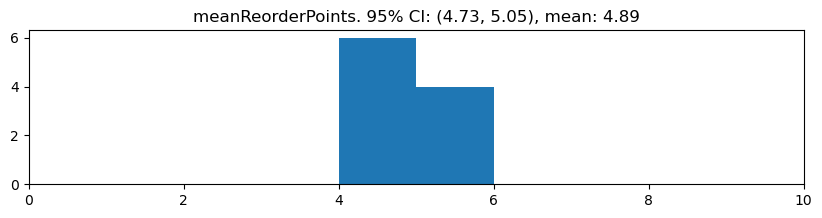

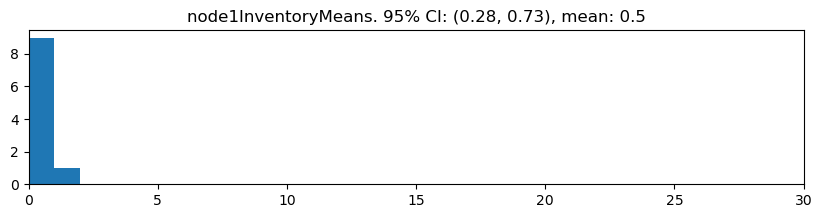

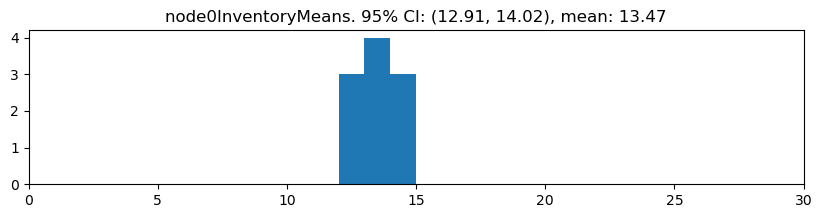

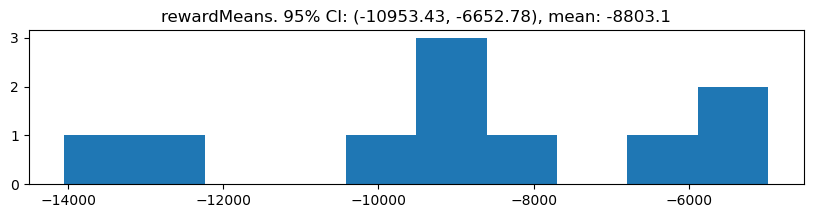

In [16]:
import scipy.stats as st

def ci(a):
    mean = np.mean(a)
    # get confidence interval
    lowerLim, upperLim = st.t.interval(0.95, len(a)-1, loc=mean, scale=st.sem(a))

    lowerLim = round(lowerLim, 2)
    mean = round(mean, 2)
    upperLim = round(upperLim, 2)
    
    return lowerLim, mean, upperLim


print(envParams, "NGame = {}".format(NGame))

plt.figure(figsize=(10, 2))
lowerLim, mean, upperLim = ci(meanReorderPoints)
plt.title("meanReorderPoints. 95% CI: ({}, {}), mean: {}".format(lowerLim, upperLim, mean))
plt.hist(meanReorderPoints, bins=range(30))
plt.xlim((0, 10))
plt.show()
plt.figure(figsize=(10, 2))
lowerLim, mean, upperLim = ci(node1InventoryMeans)
plt.title("node1InventoryMeans. 95% CI: ({}, {}), mean: {}".format(lowerLim, upperLim, mean))
plt.hist(node1InventoryMeans, bins=range(30))
plt.xlim((0, 30))
plt.show()
plt.figure(figsize=(10, 2))
lowerLim, mean, upperLim = ci(node0InventoryMeans)
plt.title("node0InventoryMeans. 95% CI: ({}, {}), mean: {}".format(lowerLim, upperLim, mean))
plt.hist(node0InventoryMeans, bins=range(30))
plt.xlim((0, 30))
plt.show()
plt.figure(figsize=(10, 2))
lowerLim, mean, upperLim = ci(rewardMeans)
plt.title("rewardMeans. 95% CI: ({}, {}), mean: {}".format(lowerLim, upperLim, mean))
plt.hist(rewardMeans)
plt.show()

In [17]:
# save experiment results

import pandas as pd
import time

timestamp = int(time.time())

filename = "{}-{}-{}_{}_{}-{}_{}_{}".format(envParams["inventoryCost"][0], envParams["inventoryCost"][1], envParams["inventoryCost"][2], envParams["stockoutCost"], envParams["muDemand"], envParams["stdDemand"], envParams["N"], NGame)

# raw data
_a = pd.DataFrame(reorderPointsAll).T
_b = pd.DataFrame(node1InventoriesAll).T
_c = pd.DataFrame(node0InventoriesAll).T
_d = pd.DataFrame(rewardsAll).T
datadf = pd.concat([_a, _b, _c, _d], axis=1, keys=['reorderPointsAll', 'node1InventoriesAll', 'node0InventoriesAll', 'rewardsAll'])

# results
resultsdf = pd.DataFrame(zip(meanReorderPoints, node1InventoryMeans, node0InventoryMeans, rewardMeans), columns=["meanReorderPoints", "node1InventoryMeans", "node0InventoryMeans", "rewardMeans"])

# metadata
metadatadf = pd.DataFrame(envParams)

metadatadf.to_csv("exp_results/qlearning_{}_{}_metadata.csv".format(filename, timestamp))
datadf.to_csv("exp_results/qlearning_{}_{}_data.csv".format(filename, timestamp))
resultsdf.to_csv("exp_results/qlearning_{}_{}_results.csv".format(filename, timestamp))

Time Series


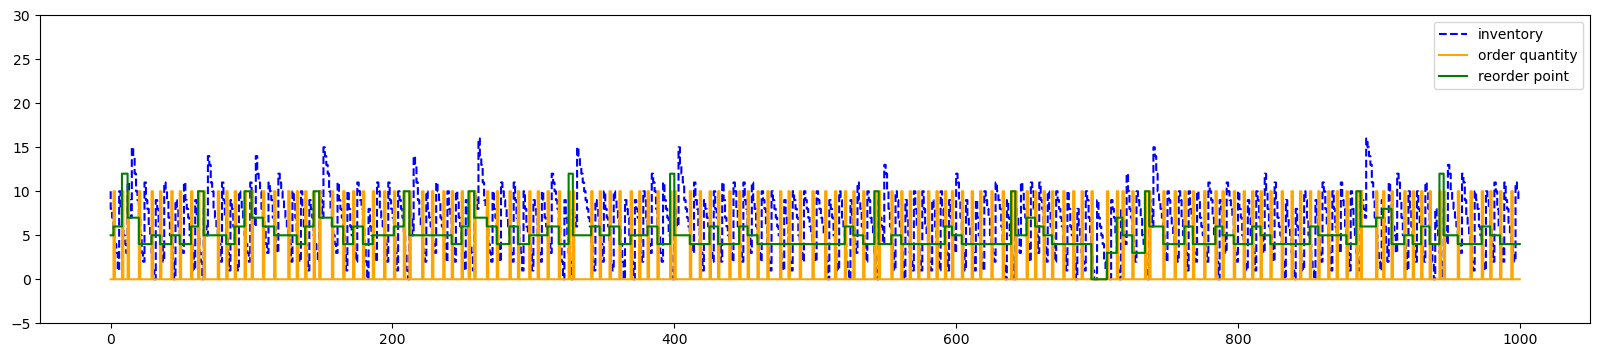

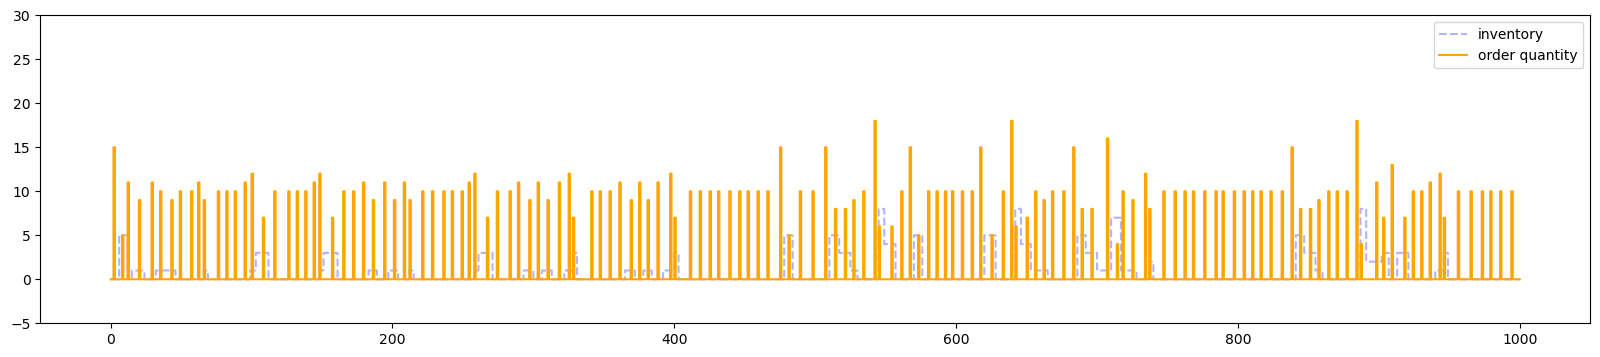

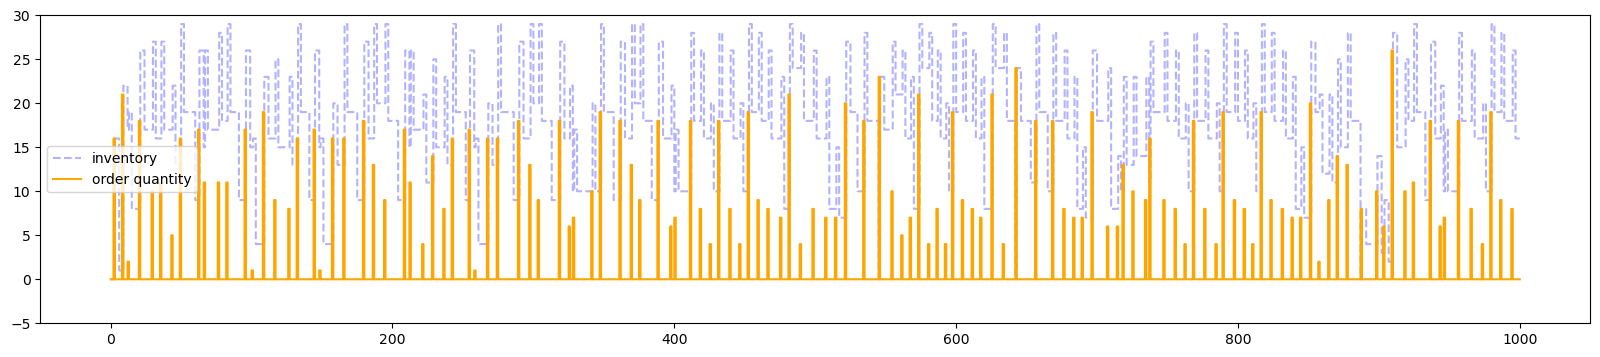

Service Time


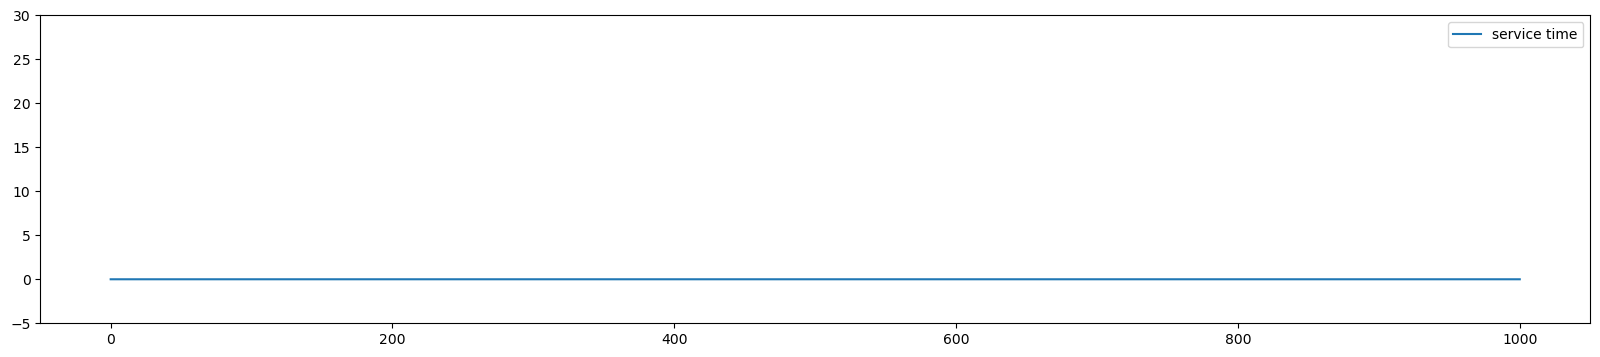

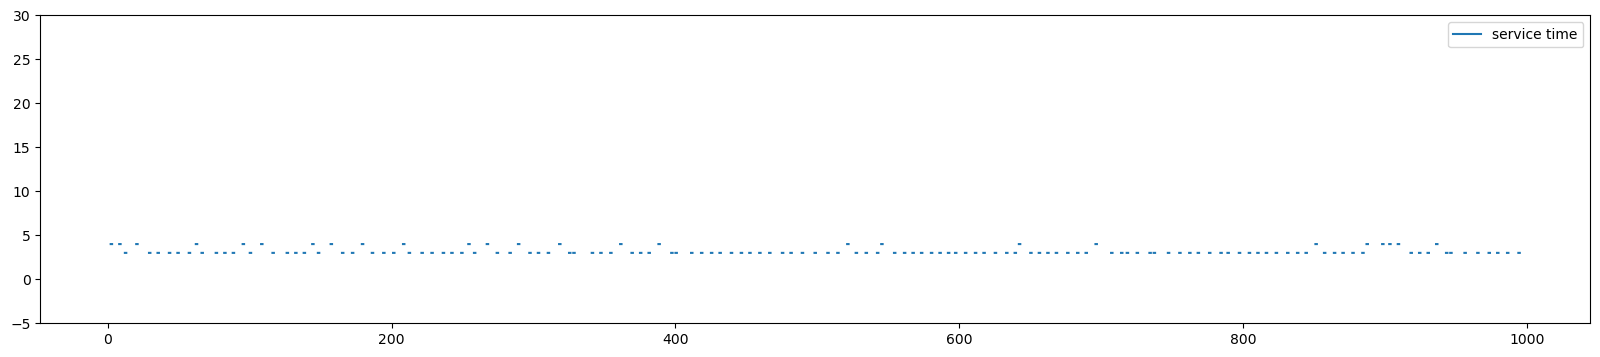

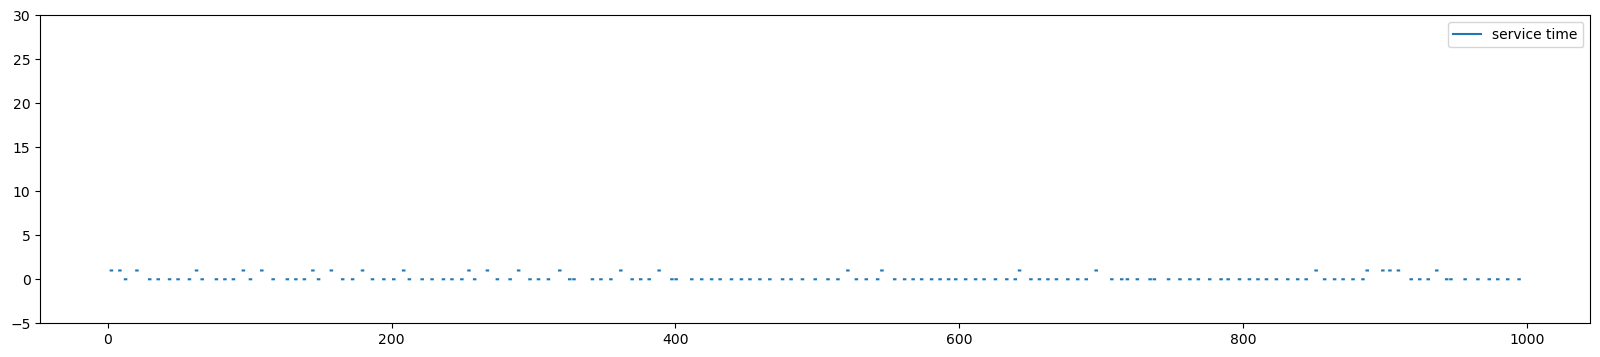

Inventory


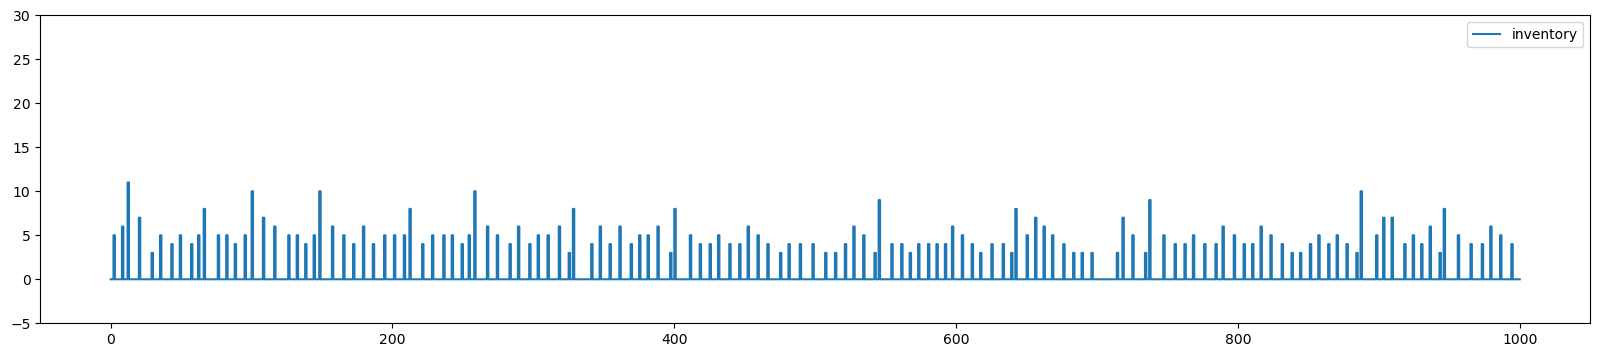

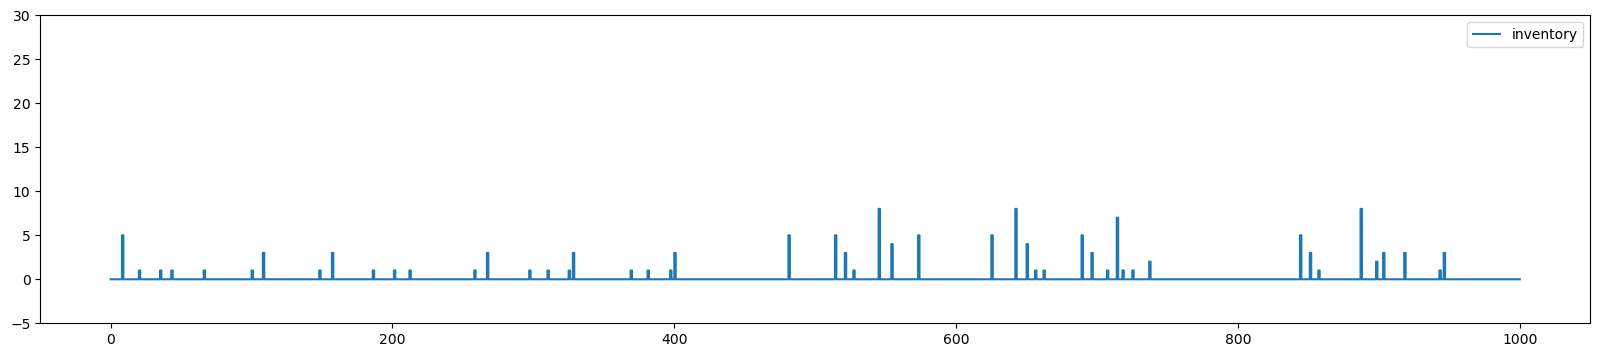

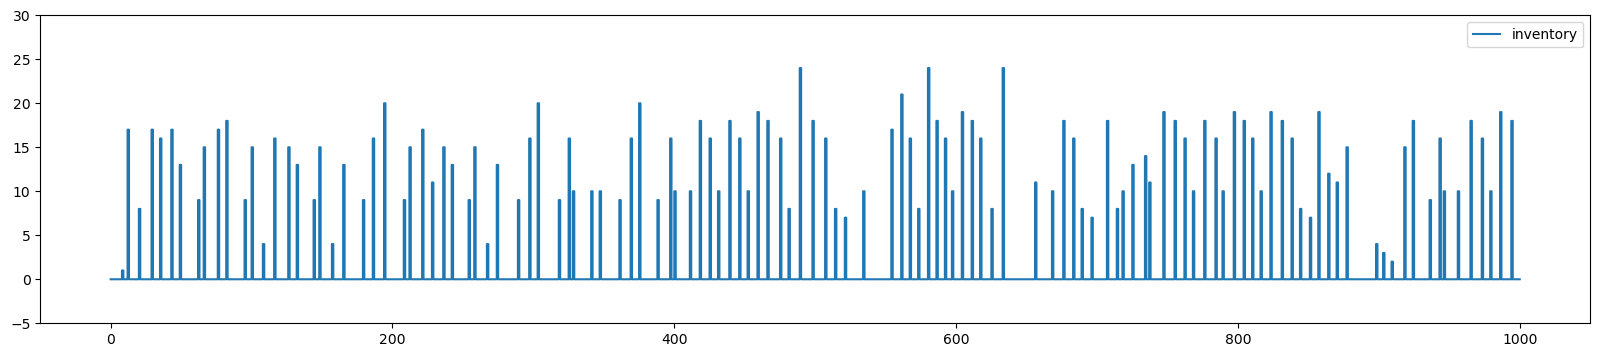

Rewards


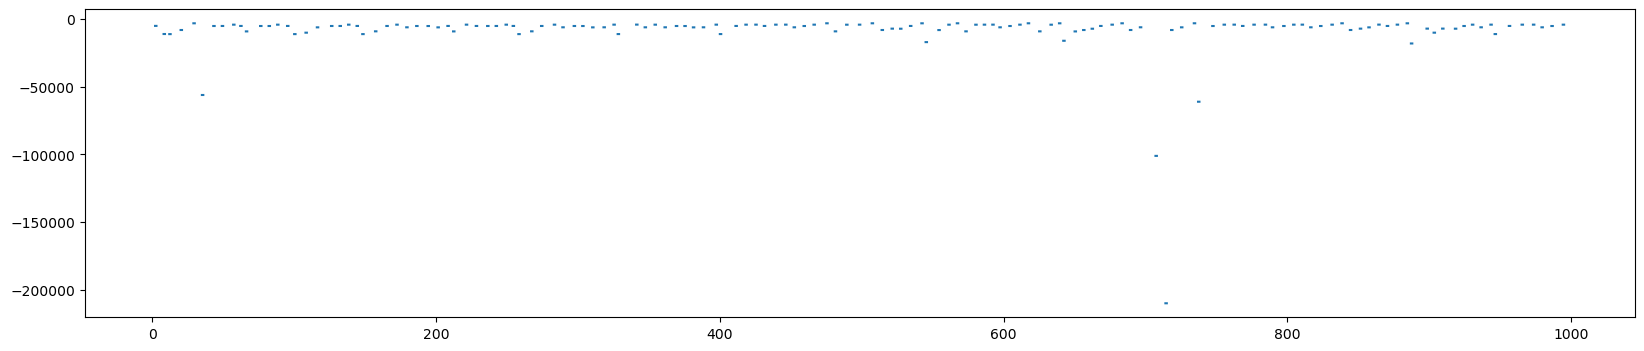

In [18]:
visualize(stateHistory, actionHistory, rewardHistory, envParams["N"])